In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/185000-128/185000.pt
/kaggle/input/225000/225000.pt
/kaggle/input/205000-25-12/205000.pt


In [7]:
import contextlib
import warnings

import torch
from torch import autograd
from torch.nn import functional as F

enabled = True
weight_gradients_disabled = False


@contextlib.contextmanager
def no_weight_gradients():
    global weight_gradients_disabled

    old = weight_gradients_disabled
    weight_gradients_disabled = True
    yield
    weight_gradients_disabled = old


def conv2d(input, weight, bias=None, stride=1, padding=0, dilation=1, groups=1):
    if could_use_op(input):
        return conv2d_gradfix(
            transpose=False,
            weight_shape=weight.shape,
            stride=stride,
            padding=padding,
            output_padding=0,
            dilation=dilation,
            groups=groups,
        ).apply(input, weight, bias)

    return F.conv2d(
        input=input,
        weight=weight,
        bias=bias,
        stride=stride,
        padding=padding,
        dilation=dilation,
        groups=groups,
    )


def conv_transpose2d(
    input,
    weight,
    bias=None,
    stride=1,
    padding=0,
    output_padding=0,
    groups=1,
    dilation=1,
):
    if could_use_op(input):
        return conv2d_gradfix(
            transpose=True,
            weight_shape=weight.shape,
            stride=stride,
            padding=padding,
            output_padding=output_padding,
            groups=groups,
            dilation=dilation,
        ).apply(input, weight, bias)

    return F.conv_transpose2d(
        input=input,
        weight=weight,
        bias=bias,
        stride=stride,
        padding=padding,
        output_padding=output_padding,
        dilation=dilation,
        groups=groups,
    )


def could_use_op(input):
    if (not enabled) or (not torch.backends.cudnn.enabled):
        return False

    if input.device.type != "cuda":
        return False

    if any(torch.__version__.startswith(x) for x in ["1.7.", "1.8."]):
        return True

    warnings.warn(
        f"conv2d_gradfix not supported on PyTorch {torch.__version__}. Falling back to torch.nn.functional.conv2d()."
    )

    return False


def ensure_tuple(xs, ndim):
    xs = tuple(xs) if isinstance(xs, (tuple, list)) else (xs,) * ndim

    return xs


conv2d_gradfix_cache = dict()


def conv2d_gradfix(
    transpose, weight_shape, stride, padding, output_padding, dilation, groups
):
    ndim = 2
    weight_shape = tuple(weight_shape)
    stride = ensure_tuple(stride, ndim)
    padding = ensure_tuple(padding, ndim)
    output_padding = ensure_tuple(output_padding, ndim)
    dilation = ensure_tuple(dilation, ndim)

    key = (transpose, weight_shape, stride, padding, output_padding, dilation, groups)
    if key in conv2d_gradfix_cache:
        return conv2d_gradfix_cache[key]

    common_kwargs = dict(
        stride=stride, padding=padding, dilation=dilation, groups=groups
    )

    def calc_output_padding(input_shape, output_shape):
        if transpose:
            return [0, 0]

        return [
            input_shape[i + 2]
            - (output_shape[i + 2] - 1) * stride[i]
            - (1 - 2 * padding[i])
            - dilation[i] * (weight_shape[i + 2] - 1)
            for i in range(ndim)
        ]

    class Conv2d(autograd.Function):
        @staticmethod
        def forward(ctx, input, weight, bias):
            if not transpose:
                out = F.conv2d(input=input, weight=weight, bias=bias, **common_kwargs)

            else:
                out = F.conv_transpose2d(
                    input=input,
                    weight=weight,
                    bias=bias,
                    output_padding=output_padding,
                    **common_kwargs,
                )

            ctx.save_for_backward(input, weight)

            return out

        @staticmethod
        def backward(ctx, grad_output):
            input, weight = ctx.saved_tensors
            grad_input, grad_weight, grad_bias = None, None, None

            if ctx.needs_input_grad[0]:
                p = calc_output_padding(
                    input_shape=input.shape, output_shape=grad_output.shape
                )
                grad_input = conv2d_gradfix(
                    transpose=(not transpose),
                    weight_shape=weight_shape,
                    output_padding=p,
                    **common_kwargs,
                ).apply(grad_output, weight, None)

            if ctx.needs_input_grad[1] and not weight_gradients_disabled:
                grad_weight = Conv2dGradWeight.apply(grad_output, input)

            if ctx.needs_input_grad[2]:
                grad_bias = grad_output.sum((0, 2, 3))

            return grad_input, grad_weight, grad_bias

    class Conv2dGradWeight(autograd.Function):
        @staticmethod
        def forward(ctx, grad_output, input):
            op = torch._C._jit_get_operation(
                "aten::cudnn_convolution_backward_weight"
                if not transpose
                else "aten::cudnn_convolution_transpose_backward_weight"
            )
            flags = [
                torch.backends.cudnn.benchmark,
                torch.backends.cudnn.deterministic,
                torch.backends.cudnn.allow_tf32,
            ]
            grad_weight = op(
                weight_shape,
                grad_output,
                input,
                padding,
                stride,
                dilation,
                groups,
                *flags,
            )
            ctx.save_for_backward(grad_output, input)

            return grad_weight

        @staticmethod
        def backward(ctx, grad_grad_weight):
            grad_output, input = ctx.saved_tensors
            grad_grad_output, grad_grad_input = None, None

            if ctx.needs_input_grad[0]:
                grad_grad_output = Conv2d.apply(input, grad_grad_weight, None)

            if ctx.needs_input_grad[1]:
                p = calc_output_padding(
                    input_shape=input.shape, output_shape=grad_output.shape
                )
                grad_grad_input = conv2d_gradfix(
                    transpose=(not transpose),
                    weight_shape=weight_shape,
                    output_padding=p,
                    **common_kwargs,
                ).apply(grad_output, grad_grad_weight, None)

            return grad_grad_output, grad_grad_input

    conv2d_gradfix_cache[key] = Conv2d

    return Conv2d

In [8]:
from collections import abc
import torch
from torch.nn import functional as F


def upfirdn2d(input, kernel, up=1, down=1, pad=(0, 0)):
    if not isinstance(up, abc.Iterable):
        up = (up, up)

    if not isinstance(down, abc.Iterable):
        down = (down, down)

    if len(pad) == 2:
        pad = (pad[0], pad[1], pad[0], pad[1])

    out = upfirdn2d_native(input, kernel, *up, *down, *pad)

    return out


def upfirdn2d_native(
    input, kernel, up_x, up_y, down_x, down_y, pad_x0, pad_x1, pad_y0, pad_y1
):
    _, channel, in_h, in_w = input.shape
    input = input.reshape(-1, in_h, in_w, 1)

    _, in_h, in_w, minor = input.shape
    kernel_h, kernel_w = kernel.shape

    out = input.view(-1, in_h, 1, in_w, 1, minor)
    out = F.pad(out, [0, 0, 0, up_x - 1, 0, 0, 0, up_y - 1])
    out = out.view(-1, in_h * up_y, in_w * up_x, minor)

    out = F.pad(
        out, [0, 0, max(pad_x0, 0), max(pad_x1, 0), max(pad_y0, 0), max(pad_y1, 0)]
    )
    out = out[
        :,
        max(-pad_y0, 0) : out.shape[1] - max(-pad_y1, 0),
        max(-pad_x0, 0) : out.shape[2] - max(-pad_x1, 0),
        :,
    ]

    out = out.permute(0, 3, 1, 2)
    out = out.reshape(
        [-1, 1, in_h * up_y + pad_y0 + pad_y1, in_w * up_x + pad_x0 + pad_x1]
    )
    w = torch.flip(kernel, [0, 1]).view(1, 1, kernel_h, kernel_w)
    out = F.conv2d(out, w)
    out = out.reshape(
        -1,
        minor,
        in_h * up_y + pad_y0 + pad_y1 - kernel_h + 1,
        in_w * up_x + pad_x0 + pad_x1 - kernel_w + 1,
    )
    out = out.permute(0, 2, 3, 1)
    out = out[:, ::down_y, ::down_x, :]

    out_h = (in_h * up_y + pad_y0 + pad_y1 - kernel_h + down_y) // down_y
    out_w = (in_w * up_x + pad_x0 + pad_x1 - kernel_w + down_x) // down_x

    return out.view(-1, channel, out_h, out_w)

In [9]:
import os

import torch
from torch import nn
from torch.nn import functional as F


class FusedLeakyReLU(nn.Module):
    def __init__(self, channel, bias=True, negative_slope=0.2, scale=2 ** 0.5):
        super().__init__()

        if bias:
            self.bias = nn.Parameter(torch.zeros(channel))

        else:
            self.bias = None

        self.negative_slope = negative_slope
        self.scale = scale

    def forward(self, input):
        return fused_leaky_relu(input, self.bias, self.negative_slope, self.scale)


def fused_leaky_relu(input, bias=None, negative_slope=0.2, scale=2 ** 0.5):
    if bias is not None:
        rest_dim = [1] * (input.ndim - bias.ndim - 1)
        return (
            F.leaky_relu(
                input + bias.view(1, bias.shape[0], *rest_dim), negative_slope=0.2
            )
            * scale
        )

    else:
        return F.leaky_relu(input, negative_slope=0.2) * scale

In [10]:
import torch, math
from torch import nn
from torch.nn import functional as F
# from op import FusedLeakyReLU, fused_leaky_relu, upfirdn2d, conv2d_gradfix

class PixelNorm(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input):
        return input * torch.rsqrt(torch.mean(input ** 2, dim=1, keepdim=True) + 1e-8)

def make_kernel(k):
    k = torch.tensor(k, dtype=torch.float32)
    if k.ndim == 1:
        k = k[None, :] * k[:, None]
    k /= k.sum()
    return k

class Upsample(nn.Module):
    def __init__(self, kernel, factor=2):
        super().__init__()

        self.factor = factor
        kernel = make_kernel(kernel) * (factor ** 2)
        self.register_buffer("kernel", kernel)
        p = kernel.shape[0] - factor
        pad0 = (p + 1) // 2 + factor - 1
        pad1 = p // 2
        self.pad = (pad0, pad1)

    def forward(self, input):
        out = upfirdn2d(input, self.kernel, up=self.factor, down=1, pad=self.pad)
        return out

class Downsample(nn.Module):
    def __init__(self, kernel, factor=2):
        super().__init__()

        self.factor = factor
        kernel = make_kernel(kernel)
        self.register_buffer("kernel", kernel)
        p = kernel.shape[0] - factor
        pad0 = (p + 1) // 2
        pad1 = p // 2
        self.pad = (pad0, pad1)

    def forward(self, input):
        out = upfirdn2d(input, self.kernel, up=1, down=self.factor, pad=self.pad)
        return out

class Blur(nn.Module):
    def __init__(self, kernel, pad, upsample_factor=1):
        super().__init__()

        kernel = make_kernel(kernel)
        if upsample_factor > 1:
            kernel = kernel * (upsample_factor ** 2)
        self.register_buffer("kernel", kernel)
        self.pad = pad

    def forward(self, input):
        out = upfirdn2d(input, self.kernel, pad=self.pad)
        return out

# https://github.com/facebookresearch/semi-discrete-flow/blob/main/model_itemsets.py#L306
class L2MultiheadAttention(nn.Module):
    """ Kim et al. "The Lipschitz Constant of Self-Attention" https://arxiv.org/abs/2006.04710 """
    def __init__(self, embed_dim, num_heads):
        super(L2MultiheadAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        assert (
            self.head_dim * num_heads == self.embed_dim
        ), "embed_dim must be divisible by num_heads"

        self.q_weight = nn.Parameter(torch.empty(embed_dim, num_heads, self.head_dim))
        self.v_weight = nn.Parameter(torch.empty(embed_dim, num_heads, self.head_dim))
        self.out_proj = nn.Linear(embed_dim, embed_dim)

        self._reset_parameters()

    def _reset_parameters(self):
        nn.init.zeros_(self.q_weight)
        nn.init.zeros_(self.v_weight)
        nn.init.zeros_(self.out_proj.weight)
        nn.init.zeros_(self.out_proj.bias)

    def forward(self, x):
        """
        Args:
            x: (T, N, D)
            attn_mask: (T, T) added to pre-softmax logits.
        """

        T, N, _ = x.shape

        q = torch.einsum("tbm,mhd->tbhd", x, self.q_weight)
        k = torch.einsum("tbm,mhd->tbhd", x, self.q_weight)
        squared_dist = (
            torch.einsum("tbhd,tbhd->tbh", q, q).unsqueeze(1)
            + torch.einsum("sbhd,sbhd->sbh", k, k).unsqueeze(0)
            - 2 * torch.einsum("tbhd,sbhd->tsbh", q, k)
        )
        attn_logits = -squared_dist / math.sqrt(self.head_dim)
        attn_weights = F.softmax(attn_logits, dim=1)  # (T, S, N, H)
        A = torch.einsum("mhd,nhd->hmn", self.q_weight, self.q_weight) / math.sqrt(
            self.head_dim
        )
        XA = torch.einsum("tbm,hmn->tbhn", x, A)
        PXA = torch.einsum("tsbh,sbhm->tbhm", attn_weights, XA)
        PXAV = torch.einsum("tbhm,mhd->tbhd", PXA, self.v_weight).reshape(
            T, N, self.embed_dim
        )
        return self.out_proj(PXAV)

class SelfAttention(nn.Module):
    def __init__(self, in_channels, embed_dim=None, num_heads=1):
        super().__init__()
        embed_dim = in_channels if embed_dim is None else embed_dim
        self.use_conv = embed_dim != in_channels
        if self.use_conv:
            self.to_input = nn.Conv2d(in_channels, embed_dim, 1, bias=True)
            self.to_output = nn.Conv2d(embed_dim, in_channels, 1, bias=True)
        self.l2attn = L2MultiheadAttention(embed_dim, num_heads)
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.GELU(),
            nn.Linear(embed_dim, embed_dim),
        )
        self.ln1 = nn.LayerNorm(embed_dim)
        self.ln2 = nn.LayerNorm(embed_dim)

    def forward(self, input):
        attn_input = self.to_input(input) if self.use_conv else input
        batch, c, h, w = attn_input.shape
        # input: [N, C, H, W] --> [N, H, W, C] --> [N, HWC]
        attn_input = attn_input.permute(0, 2, 3, 1).reshape(batch, h*w*c)
        attn_input = attn_input.reshape(batch, h*w, c)
        # [N, HW+1, C]
        norm_is = self.ln1(attn_input)
        out1 = self.l2attn(norm_is) + attn_input
        norm_out1 = self.ln2(out1)
        out2 = self.ff(norm_out1.view(-1, c)).view(batch, -1, c)
        output = out2 + out1
        # [N, HW, C]
        output = output[:, :h*w, :]
        output = output.reshape(batch, h, w, c).permute(0, 3, 1, 2)
        output = self.to_output(output) if self.use_conv else output
        return output

class TextEncoder(nn.Module):
    def __init__(self, in_dim, out_dim, num_heads=8):
        super().__init__()

        self.embedding = nn.Linear(in_dim, out_dim)
        self.l2attn = L2MultiheadAttention(out_dim, num_heads)
        self.ff = nn.Sequential(
            nn.GELU(),
            nn.Linear(out_dim, out_dim),
            nn.GELU(),
            nn.Linear(out_dim, out_dim),
        )
        self.ln1 = nn.LayerNorm(out_dim)
        self.ln2 = nn.LayerNorm(out_dim)

    def forward(self, text_embeds):
        text_embeds = self.embedding(text_embeds)
        out1 = self.l2attn(text_embeds)
        out1 = self.ln1(out1 + text_embeds)
        out2 = self.ff(out1)
        output = self.ln2(out2 + out1)
        return output

class CrossAttention(nn.Module):
    def __init__(self, in_channels, text_dim, embed_dim=None, num_heads=1, bias=False):
        super().__init__()

        self.in_channels = in_channels
        embed_dim = in_channels if embed_dim is None else embed_dim
        self.embed_dim = embed_dim
        self.use_conv = in_channels != embed_dim
        if self.use_conv:
            self.to_input = nn.Conv2d(in_channels, embed_dim, 1, bias=True)
            self.to_output = nn.Conv2d(embed_dim, in_channels, 1, bias=True)
        self.to_q = nn.Linear(embed_dim, embed_dim, bias=bias)
        self.to_k = nn.Linear(text_dim, embed_dim, bias=bias)
        self.to_v = nn.Linear(text_dim, embed_dim, bias=bias)
        self.mha = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.GELU(),
            nn.Linear(embed_dim, embed_dim),
        )
        self.ln1 = nn.LayerNorm(embed_dim)
        self.ln2 = nn.LayerNorm(embed_dim)

    def forward(self, image_embeds, text_embeds):
        ie = self.to_input(image_embeds) if self.use_conv else image_embeds
        batch, c, h, w = ie.shape
        # image_embeds: [N, C, H, W] --> [N, H, W, C] --> [N, HW, C]
        ie = ie.permute(0, 2, 3, 1).reshape(batch, h*w, c)
        norm_ie = self.ln1(ie)
        query = self.to_q(norm_ie)
        key = self.to_k(text_embeds)
        value = self.to_v(text_embeds)
        attn_output, attn_output_weights = self.mha(query, key, value)
        out1 = attn_output + ie
        out2 = self.ff(self.ln2(out1))
        # [N, HW, C]
        output = out2 + out1
        output = output.reshape(batch, h, w, c).permute(0, 3, 1, 2)
        output = self.to_output(output)if self.use_conv else output
        return output

class EqualConv2d(nn.Module):
    def __init__(
        self, in_channel, out_channel, kernel_size, stride=1, padding=0, bias=True,
    ):
        super().__init__()

        self.weight = nn.Parameter(
            torch.randn(out_channel, in_channel, kernel_size, kernel_size)
        )
        self.scale = 1 / math.sqrt(in_channel * kernel_size ** 2)

        self.stride = stride
        self.padding = padding

        if bias:
            self.bias = nn.Parameter(torch.zeros(out_channel))

        else:
            self.bias = None

    def forward(self, input):
        out = conv2d(
            input,
            self.weight * self.scale,
            bias=self.bias,
            stride=self.stride,
            padding=self.padding,
        )

        return out

    def __repr__(self):
        return (
            f"{self.__class__.__name__}({self.weight.shape[1]}, {self.weight.shape[0]},"
            f" {self.weight.shape[2]}, stride={self.stride}, padding={self.padding})"
        )

class EqualLinear(nn.Module):
    def __init__(
        self, in_dim, out_dim, bias=True, bias_init=0, lr_mul=1, activation=None,
    ):
        super().__init__()

        self.weight = nn.Parameter(torch.randn(out_dim, in_dim).div_(lr_mul))

        if bias:
            self.bias = nn.Parameter(torch.zeros(out_dim).fill_(bias_init))

        else:
            self.bias = None

        self.activation = activation

        self.scale = (1 / math.sqrt(in_dim)) * lr_mul
        self.lr_mul = lr_mul

    def forward(self, input):
        if self.activation:
            out = F.linear(input, self.weight * self.scale)
            out = fused_leaky_relu(out, self.bias * self.lr_mul)

        else:
            out = F.linear(
                input, self.weight * self.scale, bias=self.bias * self.lr_mul
            )

        return out

    def __repr__(self):
        return (
            f"{self.__class__.__name__}({self.weight.shape[1]}, {self.weight.shape[0]})"
        )

class ModulatedConv2d(nn.Module):
    def __init__(
        self, in_channel, out_channel, kernel_size, style_dim, n_kernel=1, demodulate=True,
        upsample=False, downsample=False, blur_kernel=[1, 3, 3, 1],
    ):
        super().__init__()

        self.eps = 1e-8
        self.kernel_size = kernel_size
        self.in_channel = in_channel
        self.out_channel = out_channel
        self.upsample = upsample
        self.downsample = downsample
        self.n_kernel = n_kernel

        if upsample:
            factor = 2
            p = (len(blur_kernel) - factor) - (kernel_size - 1)
            pad0 = (p + 1) // 2 + factor - 1
            pad1 = p // 2 + 1

            self.blur = Blur(blur_kernel, pad=(pad0, pad1), upsample_factor=factor)

        if downsample:
            factor = 2
            p = (len(blur_kernel) - factor) + (kernel_size - 1)
            pad0 = (p + 1) // 2
            pad1 = p // 2

            self.blur = Blur(blur_kernel, pad=(pad0, pad1))

        fan_in = in_channel * kernel_size ** 2
        self.scale = 1 / math.sqrt(fan_in)
        self.padding = kernel_size // 2
        # conv weight shape: out_ch, in_ch, k_h, k_w
        self.weight = nn.Parameter(torch.randn((n_kernel, out_channel, in_channel, kernel_size, kernel_size)))
        if self.n_kernel != 1:
            self.affine = nn.Linear(style_dim, n_kernel)
        self.modulation = EqualLinear(style_dim, in_channel, bias_init=1)
        self.demodulate = demodulate

    def __repr__(self):
        return (
            f"{self.__class__.__name__}({self.in_channel}, {self.out_channel}, {self.kernel_size}, "
            f"upsample={self.upsample}, downsample={self.downsample})"
        )

    def forward(self, input, style):
        batch, in_channel, height, width = input.shape
        if self.n_kernel != 1:
            selection = self.affine(style).softmax(dim=-1)
            selection = selection.view(-1, self.n_kernel, 1, 1, 1, 1)
            ada_weight = (selection * self.weight).sum(dim=1)
        else:
            ada_weight = self.weight

        style = self.modulation(style).view(batch, 1, in_channel, 1, 1)
        weight = self.scale * ada_weight * style

        if self.demodulate:
            demod = torch.rsqrt(weight.pow(2).sum([2, 3, 4]) + 1e-8)
            weight = weight * demod.view(batch, self.out_channel, 1, 1, 1)

        weight = weight.view(
            batch * self.out_channel, in_channel, self.kernel_size, self.kernel_size
        )

        if self.upsample:
            input = input.reshape(1, batch * in_channel, height, width)
            weight = weight.view(
                batch, self.out_channel, in_channel, self.kernel_size, self.kernel_size
            )
            weight = weight.transpose(1, 2).reshape(
                batch * in_channel, self.out_channel, self.kernel_size, self.kernel_size
            )
            out = conv_transpose2d(
                input, weight, padding=0, stride=2, groups=batch
            )
            _, _, height, width = out.shape
            out = out.view(batch, self.out_channel, height, width)
            out = self.blur(out)

        elif self.downsample:
            input = self.blur(input)
            _, _, height, width = input.shape
            input = input.view(1, batch * in_channel, height, width)
            out = conv2d(
                input, weight, padding=0, stride=2, groups=batch
            )
            _, _, height, width = out.shape
            out = out.view(batch, self.out_channel, height, width)

        else:
            input = input.reshape(1, batch * in_channel, height, width)
            out = conv2d(
                input, weight, padding=self.padding, groups=batch
            )
            _, _, height, width = out.shape
            out = out.view(batch, self.out_channel, height, width)

        return out

class NoiseInjection(nn.Module):
    def __init__(self):
        super().__init__()

        self.weight = nn.Parameter(torch.zeros(1))

    def forward(self, image, noise=None):
        if noise is None:
            batch, _, height, width = image.shape
            noise = image.new_empty(batch, 1, height, width).normal_()

        return image + self.weight * noise

class ConstantInput(nn.Module):
    def __init__(self, channel, size=4):
        super().__init__()

        self.input = nn.Parameter(torch.randn(1, channel, size, size))

    def forward(self, input):
        batch = input.shape[0]
        out = self.input.repeat(batch, 1, 1, 1)

        return out

class StyledConv(nn.Module):
    def __init__(
        self, in_channel, out_channel, kernel_size, style_dim,
        n_kernel=1, upsample=False, blur_kernel=[1, 3, 3, 1], demodulate=True,
    ):
        super().__init__()

        self.conv = ModulatedConv2d(
            in_channel, out_channel, kernel_size, style_dim, n_kernel=n_kernel,
            upsample=upsample, blur_kernel=blur_kernel, demodulate=demodulate,
        )

        self.noise = NoiseInjection()
        self.activate = FusedLeakyReLU(out_channel)

    def forward(self, input, style, noise=None):
        out = self.conv(input, style)
        out = self.noise(out, noise=noise)
        out = self.activate(out)

        return out

class ToRGB(nn.Module):
    def __init__(self, in_channel, style_dim, upsample=True, blur_kernel=[1, 3, 3, 1]):
        super().__init__()

        if upsample:
            self.upsample = Upsample(blur_kernel)

        self.conv = ModulatedConv2d(in_channel, 3, 1, style_dim, demodulate=False)
        self.bias = nn.Parameter(torch.zeros(1, 3, 1, 1))

    def forward(self, input, style, skip=None):
        out = self.conv(input, style)
        out = out + self.bias

        if skip is not None:
            skip = self.upsample(skip)

            out = out + skip

        return out

class FromRGB(nn.Module):
    def __init__(self, in_channel, out_channel):
        super().__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(in_channel, 256, 3, padding='same'),
            nn.LeakyReLU(),
            nn.Conv2d(256, out_channel, 1),
        )

    def forward(self, input):
        return self.convs(input)

In [11]:
import math
import random
import torch, inspect
from torch import nn, optim
from torch.nn import functional as F
# from op import FusedLeakyReLU, fused_leaky_relu, upfirdn2d, conv2d_gradfix

# from layers import (
#     PixelNorm, ToRGB, ConstantInput, StyledConv, Blur, EqualConv2d,
#     ModulatedConv2d, EqualLinear, FromRGB,
#     SelfAttention, CrossAttention, TextEncoder,
# )

def append_if(condition, var, elem):
    if (condition):
        var.append(elem)

class Generator(nn.Module):
    def __init__(
        self, size, z_dim, n_mlp, tin_dim=0, tout_dim=0,
        channel_multiplier=2, blur_kernel=[1, 3, 3, 1], lr_mlp=0.01,
        use_self_attn=False, use_text_cond=False, use_multi_scale=False,
        attn_res=[8, 16, 32],
    ):
        super().__init__()

        self.size = size
        self.use_multi_scale = use_multi_scale
        self.use_self_attn = use_self_attn
        self.use_text_cond = use_text_cond
        if use_text_cond:
            self.style_dim = z_dim + tout_dim
            self.text_encoder = TextEncoder(tin_dim, tout_dim)
        else:
            self.style_dim = z_dim

        layers = [PixelNorm()]
        for i in range(n_mlp):
            layers.append(
                EqualLinear(
                    self.style_dim, self.style_dim, lr_mul=lr_mlp, activation="fused_lrelu"
                )
            )

        self.style = nn.Sequential(*layers)

        self.channels = {
            4: 512, 8: 512, 16: 512, 32: 512, 64: 256 * channel_multiplier,
            128: 128 * channel_multiplier, 256: 64 * channel_multiplier,
            512: 32 * channel_multiplier, 1024: 16 * channel_multiplier,
        }
        n_kernels = {
            4: 1, 8: 1, 16: 2, 32: 4, 64: 8,
            128: 8, 256: 8, 512: 8, 1024: 8,
        }

        self.input = ConstantInput(self.channels[4])
        self.conv1 = StyledConv(
            self.channels[4], self.channels[4], 3, self.style_dim, blur_kernel=blur_kernel
        )
        self.to_rgb1 = ToRGB(self.channels[4], self.style_dim, upsample=False)

        self.log_size = int(math.log(size, 2))
        self.num_layers = (self.log_size - 2) * 2 + 1

        self.convs = nn.ModuleList()
        self.attns = nn.ModuleList()
        self.upsamples = nn.ModuleList()
        self.to_rgbs = nn.ModuleList()
        self.noises = nn.Module()

        in_channel = self.channels[4]

        for layer_idx in range(self.num_layers):
            res = (layer_idx + 5) // 2
            shape = [1, 1, 2 ** res, 2 ** res]
            self.noises.register_buffer(f"noise_{layer_idx}", torch.randn(*shape))

        for i in range(3, self.log_size + 1):
            res = 2 ** i
            out_channel = self.channels[res]

            self.convs.append(StyledConv(
                in_channel, out_channel, 3, self.style_dim, upsample=True,
                blur_kernel=blur_kernel, n_kernel=n_kernels[res],
            ))
            self.convs.append(StyledConv(
                out_channel, out_channel, 3, self.style_dim, blur_kernel=blur_kernel,
                n_kernel=n_kernels[res],
            ))

            self.attns.append(
                SelfAttention(out_channel) if use_self_attn and res in attn_res else None
            )
            self.attns.append(
                CrossAttention(out_channel, tout_dim) if use_text_cond and res in attn_res else None
            )

            self.to_rgbs.append(ToRGB(out_channel, self.style_dim))

            in_channel = out_channel

        self.n_latent = self.log_size * 2 - 2

    def make_noise(self):
        device = self.input.input.device

        noises = [torch.randn(1, 1, 2 ** 2, 2 ** 2, device=device)]

        for i in range(3, self.log_size + 1):
            for _ in range(2):
                noises.append(torch.randn(1, 1, 2 ** i, 2 ** i, device=device))

        return noises

    def mean_latent(self, n_latent):
        latent_in = torch.randn(
            n_latent, self.style_dim, device=self.input.input.device
        )
        latent = self.style(latent_in).mean(0, keepdim=True)

        return latent

    def get_latent(self, input):
        return self.style(input)

    def forward(
        self, styles, text_embeds=None,
        return_latents=False, inject_index=None, truncation=1, truncation_latent=None,
        input_is_latent=False, noise=None, randomize_noise=True,
    ):
        if self.use_text_cond:
            seq_len = text_embeds.shape[1]
            text_embeds = self.text_encoder(text_embeds)
            t_local, t_global = torch.split(text_embeds, [seq_len-1, 1], dim=1)
            # batch, tout_dim
            t_global = t_global.squeeze(dim=1)
            styles = [torch.cat([style_, t_global], dim=1) for style_ in styles]

        if not input_is_latent:
            styles = [self.style(s) for s in styles]

        if noise is None:
            if randomize_noise:
                noise = [None] * self.num_layers
            else:
                noise = [
                    getattr(self.noises, f"noise_{i}") for i in range(self.num_layers)
                ]

        if truncation < 1:
            style_t = []

            for style in styles:
                style_t.append(
                    truncation_latent + truncation * (style - truncation_latent)
                )

            styles = style_t

        if len(styles) < 2:
            inject_index = self.n_latent

            if styles[0].ndim < 3:
                latent = styles[0].unsqueeze(1).repeat(1, inject_index, 1)

            else:
                latent = styles[0]

        else:
            if inject_index is None:
                inject_index = random.randint(1, self.n_latent - 1)

            latent = styles[0].unsqueeze(1).repeat(1, inject_index, 1)
            latent2 = styles[1].unsqueeze(1).repeat(1, self.n_latent - inject_index, 1)

            latent = torch.cat([latent, latent2], 1)

        images = []
        out = self.input(latent)
        out = self.conv1(out, latent[:, 0], noise=noise[0])
        skip = self.to_rgb1(out, latent[:, 1])
        append_if(self.use_multi_scale, images, skip)

        i = 1
        for conv1, conv2, noise1, noise2, to_rgb, self_attn, cross_attn in zip(
            self.convs[::2], self.convs[1::2], noise[1::2], noise[2::2], self.to_rgbs,
            self.attns[::2], self.attns[1::2],
        ):
            out = conv1(out, latent[:, i], noise=noise1)
            out = conv2(out, latent[:, i + 1], noise=noise2)
            if self_attn: out = self_attn(out)
            if cross_attn: out = cross_attn(out, t_local)
            skip = to_rgb(out, latent[:, i + 2], skip)
            append_if(self.use_multi_scale, images, skip)

            i += 2

        # images: [4x, 8x, ..., 32x, 64x] or [64x]
        if not self.use_multi_scale:
            images = [skip]

        if return_latents:
            return images, latent
        else:
            return images, None

    def set_optim(self, lr=0.0025, betas=(0, 0.99), weight_decay= 0.00001, attn_weight_decay=0.01):
        if not (self.use_self_attn or self.use_text_cond):
            g_optim = optim.AdamW(self.parameters(), lr=lr, betas=betas, weight_decay=weight_decay)
        else:
            param_dict = {pn: p for pn, p in self.named_parameters()}
            decay, attn_decay = set(param_dict.keys()), set()
            attn_types = (SelfAttention, CrossAttention)
            for mn, m in self.named_modules():
                if isinstance(m, attn_types):
                    for pn, p in m.named_parameters():
                        # full param name
                        mpn = '%s.%s' % (mn, pn) if mn else pn
                        attn_decay.add(mpn)
                        decay.remove(mpn)

            optim_groups = [
                {"params": [param_dict[pn] for pn in sorted(list(decay))], "weight_decay": weight_decay},
                {"params": [param_dict[pn] for pn in sorted(list(attn_decay))], "weight_decay": attn_weight_decay},
            ]
            # new PyTorch nightly has a new 'fused' option for AdamW that is much faster
            use_fused = 'fused' in inspect.signature(torch.optim.AdamW).parameters
            print(f"using fused AdamW: {use_fused}")
            extra_args = dict(fused=True) if use_fused else dict()
            g_optim = optim.AdamW(optim_groups, lr=lr, betas=betas, **extra_args)

        return g_optim

In [12]:
class Args:
    def __init__(self):
        self.latent = 512
        self.n_mlp = 8
        self.start_iter = 0
        self.tin_dim = 0
        self.tout_dim = 0
        self.use_multi_scale = False
        self.use_text_cond = False
        self.g_use_self_attn = False
        self.d_use_self_attn = False
    def add(self,name,x):
          setattr(self, name, x)

In [13]:
args = Args()

args.add('device','cuda')
args.add('path', "VuongQuoc/english_learn")
args.add('n_sample',8)
args.add('size', 128)
args.add('r1',10)
args.add('d_reg_every', 16)
args.add('ckpt','/kaggle/input/225000/225000.pt')
args.add('lr', 0.005)
args.add('channel_multiplier', 2)
args.add('augment_p', 0)
args.add('ada_target', 0.6)
args.add('ada_length', (500 * 1000))
args.add('ada_every', 256)

# args.latent = 512
# args.n_mlp = 8
# args.start_iter = 0
# args.tin_dim = 0
# args.tout_dim = 0
# args.use_multi_scale = False
# args.use_text_cond = False
# args.g_use_self_attn = False
# args.d_use_self_attn = False

device = args.device

In [14]:
g_ema = Generator(
    args.size, args.latent, args.n_mlp, args.tin_dim, args.tout_dim,
    channel_multiplier=args.channel_multiplier, use_multi_scale=args.use_multi_scale,
    use_text_cond=args.use_text_cond, use_self_attn=args.g_use_self_attn,
).to(device)
g_ema.eval()

Generator(
  (style): Sequential(
    (0): PixelNorm()
    (1): EqualLinear(512, 512)
    (2): EqualLinear(512, 512)
    (3): EqualLinear(512, 512)
    (4): EqualLinear(512, 512)
    (5): EqualLinear(512, 512)
    (6): EqualLinear(512, 512)
    (7): EqualLinear(512, 512)
    (8): EqualLinear(512, 512)
  )
  (input): ConstantInput()
  (conv1): StyledConv(
    (conv): ModulatedConv2d(512, 512, 3, upsample=False, downsample=False)
    (noise): NoiseInjection()
    (activate): FusedLeakyReLU()
  )
  (to_rgb1): ToRGB(
    (conv): ModulatedConv2d(512, 3, 1, upsample=False, downsample=False)
  )
  (convs): ModuleList(
    (0): StyledConv(
      (conv): ModulatedConv2d(512, 512, 3, upsample=True, downsample=False)
      (noise): NoiseInjection()
      (activate): FusedLeakyReLU()
    )
    (1): StyledConv(
      (conv): ModulatedConv2d(512, 512, 3, upsample=False, downsample=False)
      (noise): NoiseInjection()
      (activate): FusedLeakyReLU()
    )
    (2): StyledConv(
      (conv): Modul

# **#CLIP MODEL text to vector**

In [15]:
import torch, transformers
from transformers import CLIPTokenizer, CLIPTextModel

# from transformers/models/clip/modeling_clip.py
def contrastive_loss(logits: torch.Tensor) -> torch.Tensor:
    return torch.nn.functional.cross_entropy(logits, torch.arange(len(logits), device=logits.device))

def clip_loss(similarity: torch.Tensor) -> torch.Tensor:
    caption_loss = contrastive_loss(similarity)
    image_loss = contrastive_loss(similarity.t())
    return (caption_loss + image_loss) / 2.0

class CLIPText():
    def __init__(self, device, model_id='openai/clip-vit-base-patch32', cache_dir='.'):
        self.model_id = model_id
        self.device = device
        transformers.logging.set_verbosity_error()
        self.text_encoder = CLIPTextModel.from_pretrained(self.model_id, cache_dir=cache_dir).to(device)
        self.tokenizer = CLIPTokenizer.from_pretrained(self.model_id, cache_dir=cache_dir)
        transformers.logging.set_verbosity_warning()

    @torch.no_grad()
    def __call__(self, text):
        text_inputs = self.tokenizer(
            text, padding="max_length", max_length=self.tokenizer.model_max_length,
            truncation=True, return_tensors="pt",
        )
        text_input_ids = text_inputs.input_ids
        # (last_hidden_state, pooled_output, encoder_outputs[1:])
        text_embeds = self.text_encoder(text_input_ids.to(self.device))
        text_embeds = text_embeds[0]
        return text_embeds

    @property
    def model_max_length(self):
        return self.tokenizer.model_max_length

    @property
    def hidden_size(self):
        return self.text_encoder.config.hidden_size

In [16]:
ckpt = torch.load(args.ckpt, map_location=lambda storage, loc: storage)
g_ema.load_state_dict(ckpt["g_ema"])
g_ema.eval()

Generator(
  (style): Sequential(
    (0): PixelNorm()
    (1): EqualLinear(512, 512)
    (2): EqualLinear(512, 512)
    (3): EqualLinear(512, 512)
    (4): EqualLinear(512, 512)
    (5): EqualLinear(512, 512)
    (6): EqualLinear(512, 512)
    (7): EqualLinear(512, 512)
    (8): EqualLinear(512, 512)
  )
  (input): ConstantInput()
  (conv1): StyledConv(
    (conv): ModulatedConv2d(512, 512, 3, upsample=False, downsample=False)
    (noise): NoiseInjection()
    (activate): FusedLeakyReLU()
  )
  (to_rgb1): ToRGB(
    (conv): ModulatedConv2d(512, 3, 1, upsample=False, downsample=False)
  )
  (convs): ModuleList(
    (0): StyledConv(
      (conv): ModulatedConv2d(512, 512, 3, upsample=True, downsample=False)
      (noise): NoiseInjection()
      (activate): FusedLeakyReLU()
    )
    (1): StyledConv(
      (conv): ModulatedConv2d(512, 512, 3, upsample=False, downsample=False)
      (noise): NoiseInjection()
      (activate): FusedLeakyReLU()
    )
    (2): StyledConv(
      (conv): Modul

In [18]:
args.use_text_cond = True
text_encoder = CLIPText(args.device) if args.use_text_cond else None

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


tokenizer_config.json:   0%|          | 0.00/568 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

Input text and convert to vector and predict image

In [51]:
from torchvision import  utils
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def gen_image(input_text):
    sample_t = text_encoder(input_text)
    sample_t = sample_t.repeat(args.n_sample, 1, 1).detach()
    sample_z = torch.randn(1, args.latent, device=device)
    sample, _ = g_ema([sample_z], sample_t)
    utils.save_image(
        sample[-1], f"/kaggle/working/sample.png",
        nrow=int(math.sqrt(args.n_sample)), normalize=True, value_range=(-1, 1),
        )

    img = mpimg.imread("/kaggle/working/sample.png")

    plt.imshow(img)
    plt.axis('off')  
    plt.show()

/tmp/ipykernel_34/2257113925.py:88: UserWarning: conv2d_gradfix not supported on PyTorch 2.1.2. Falling back to torch.nn.functional.conv2d().
  warnings.warn(


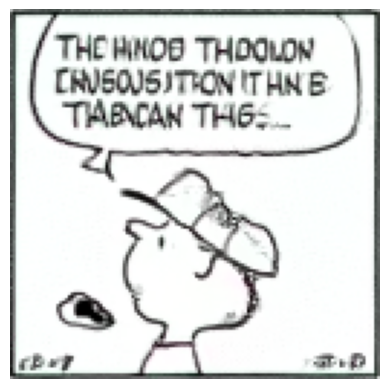

In [52]:
input_text = "so then said to him snoopy cartoon"
gen_image(input_text)